In [18]:
from sklearn.cluster import KMeans # KMedoids clust = KMedoids(n_clusters=20, random_state=0, metric='euclidean').fit(d1)
from sklearn.cluster import BisectingKMeans
import numpy as np
import joblib
import os, yaml, sys
ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from dim_redu_anns.utils import get_relevant_output_layers
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from alignment.utils import get_usual_transform
from math import ceil
import math

In [19]:
transform = transforms.Compose(
    [      
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
) 
    
dataset = datasets.ImageFolder(f"{paths["data_path"]}/imagenet", transform=transform)

In [20]:
model_name1 = "resnet50"
model_name2 = "vit_b_16"
layers1 = get_relevant_output_layers(model_name1); layer_idx1 = 17
layers2 = get_relevant_output_layers(model_name2); layer_idx2 = 8
target_layer1 = layers1[layer_idx1]
target_layer2 = layers2[layer_idx2]

pooling = "maxpool"
n_components_cca = 50
feats_path1 = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_features.pkl"
feats1 = joblib.load(feats_path1)
PCs1_path = f"{paths["results_path"]}/imagenet_val_{model_name1}_{target_layer1}_{pooling}_pca_model_1000_PCs.pkl"
PCs1 = joblib.load(PCs1_path)
feats_path2 = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_features.pkl"
feats2 = joblib.load(feats_path2)
PCs2_path = f"{paths["results_path"]}/imagenet_val_{model_name2}_{target_layer2}_{pooling}_pca_model_1000_PCs.pkl"
PCs2 = joblib.load(PCs2_path)
cca_path = f"{paths["results_path"]}/cca_{model_name1}_vs_{model_name2}_{pooling}/cca_{model_name1}_vs_{model_name2}_{n_components_cca}_components_pca_{target_layer1}_vs_{target_layer2}.pkl"

weights_dict = joblib.load(cca_path)

In [21]:
dim_rid1 = feats1@PCs1.components_.T
if feats1.shape[1]>1000:
    d1 = dim_rid1 @ weights_dict["W1"]
else:
    d1 = feats1 @ weights_dict["W1"]

dim_rid2 = feats2@PCs2.components_.T
if feats2.shape[1]>1000:
    d2 = dim_rid2 @ weights_dict["W2"]
else:
    d2 = feats2 @ weights_dict["W2"]

In [32]:
clust_num = 100
clust = KMeans(n_clusters=clust_num, init='k-means++', n_init='auto', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(d2)
#print(clust.cluster_centers_)
#print(clust.labels_)
bclust = BisectingKMeans(n_clusters=clust_num, init='k-means++', max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True, algorithm='lloyd').fit(d2)

In [33]:
d1_low_dim = (feats1@PCs1.components_.T) @ weights_dict["W1"][:,:2]
centroids = clust.cluster_centers_
bcentroids = bclust.cluster_centers_

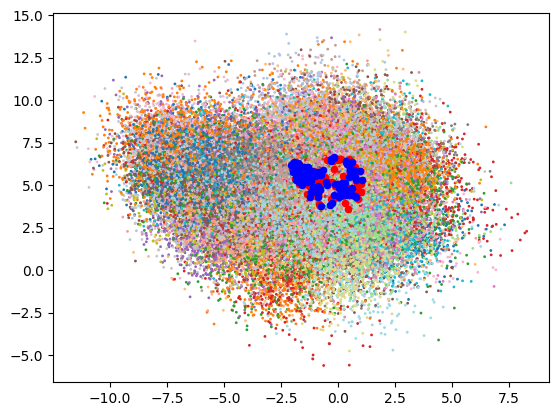

In [34]:
plt.scatter(d1_low_dim[:,0],d1_low_dim[:,1], c=clust.labels_, cmap="tab20", s=1) 
plt.scatter(centroids[:, 0], centroids[:, 1], s=20, color='red', label='Data 2')
plt.scatter(bcentroids[:, 0], bcentroids[:, 1], s=20, color='blue', label='Data 2')

In [8]:
r_idx = np.random.choice(d1_low_dim.shape[0], size=300,replace=False)

In [9]:
pts2plot =d1_low_dim[r_idx, :]

In [10]:
imgs = [dataset[i][0].permute(1,2,0) for i in r_idx]

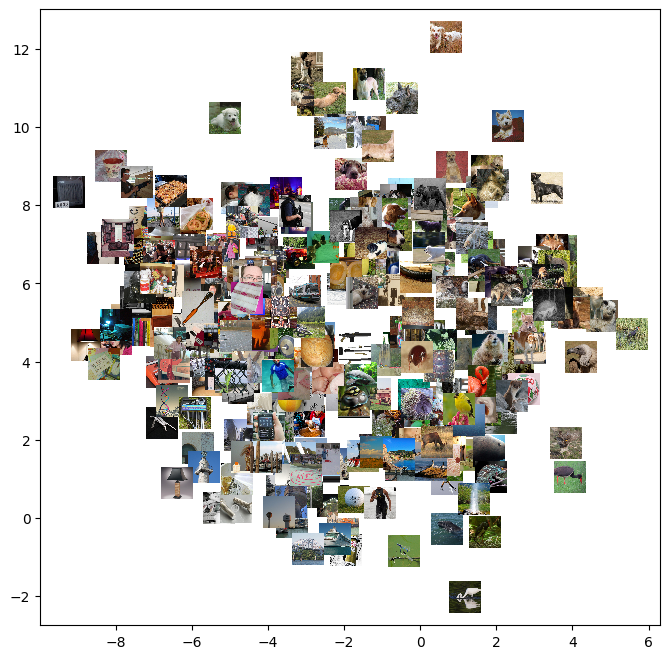

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot (optional if you only want images)
ax.scatter(pts2plot[:, 0], pts2plot[:, 1], alpha=0.3)
for (x, y), img in zip(pts2plot, imgs):
    imagebox = OffsetImage(np.clip(img, 0,1), zoom=0.1, alpha=1)  # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

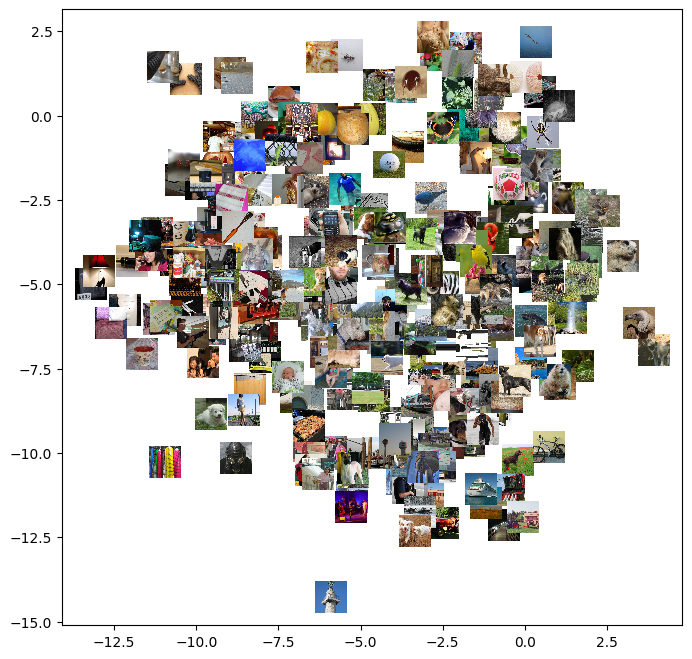

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
sing_pts2plot = feats1 @ PCs1.components_[:2,:].T
sing_pts2plot = sing_pts2plot[r_idx,:]
# Scatter plot (optional if you only want images)
ax.scatter(sing_pts2plot[:, 0], sing_pts2plot[:, 1], alpha=0.3)
for (x, y), img in zip(sing_pts2plot, imgs):
    imagebox = OffsetImage(np.clip(img, 0,1), zoom=0.1, alpha=1)  # Adjust zoom as needed
    ab = AnnotationBbox(imagebox, (x, y), frameon=False)
    ax.add_artist(ab)

In [13]:
tot_num = 40
N = ceil(tot_num / clust_num)
sampled_indices = []
for cluster_id in range(clust_num):
    indices = np.where(clust.labels_ == cluster_id)[0]
    sampled_indices.append(np.random.choice(indices, size=N, replace=False))
sampled_indices = np.concatenate(sampled_indices)

In [14]:
def plot_imgs(imgs):
    n_imgs = len(imgs)
    square_size = 8  # inches
    n_cols = math.ceil(math.sqrt(n_imgs))
    n_rows = math.ceil(n_imgs / n_cols)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(square_size, square_size),gridspec_kw=dict(wspace=0, hspace=0))
    
    # Flatten axes for easy indexing
    axes = axes.flatten()
    
    for i in range(n_imgs):
        axes[i].imshow(imgs[i])  # Replace with your image array
        axes[i].axis('off')
    
    # Hide any extra axes (if grid is larger than number of images)
    for i in range(n_imgs, len(axes)):
        axes[i].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove spacing between subplots
    plt.show()
    
    return fig


In [15]:
imgs = [dataset[i][0].permute(1,2,0) for i in sampled_indices]

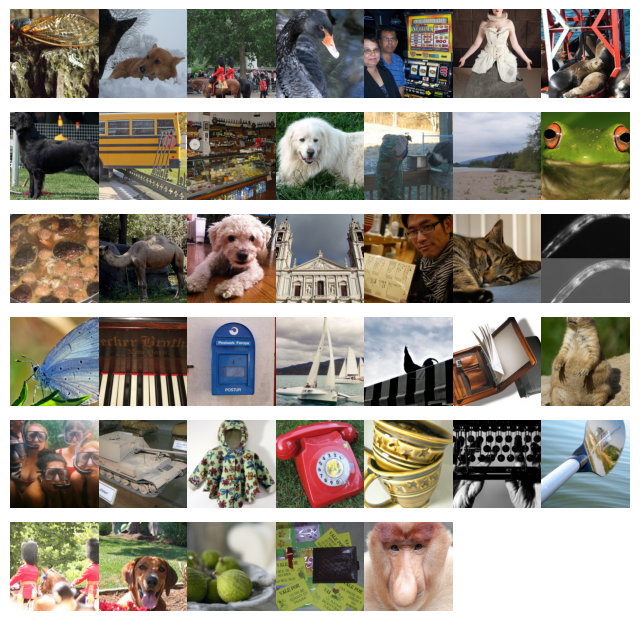

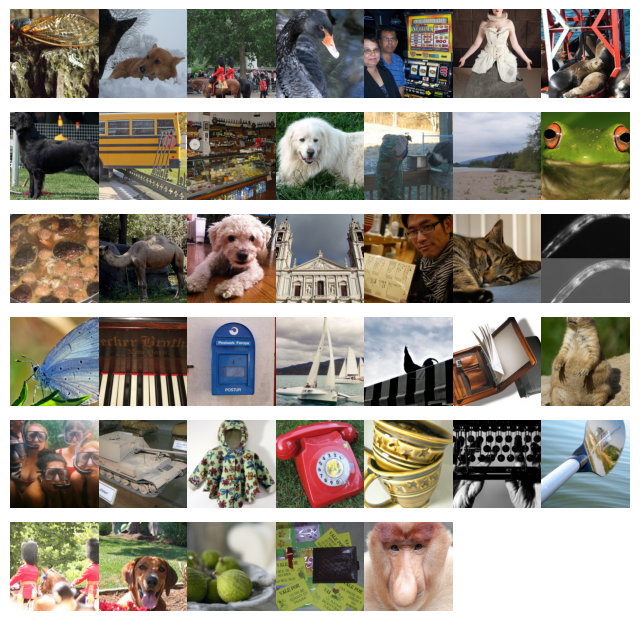

In [16]:
plot_imgs(imgs)